## Clasificatori de bucătărie 1

În această lecție, vom explora o varietate de clasificatori pentru a *prezice o bucătărie națională dată pe baza unui grup de ingrediente.* În timp ce facem acest lucru, vom învăța mai multe despre modurile în care algoritmii pot fi utilizați pentru sarcini de clasificare.

### [**Chestionar înainte de lecție**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Pregătire**

Această lecție se bazează pe [lecția noastră anterioară](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) unde:

-   Am făcut o introducere ușoară în clasificări folosind un set de date despre toate bucătăriile minunate din Asia și India 😋.

-   Am explorat câteva [verbe dplyr](https://dplyr.tidyverse.org/) pentru a pregăti și curăța datele noastre.

-   Am realizat vizualizări frumoase folosind ggplot2.

-   Am demonstrat cum să gestionăm datele dezechilibrate prin preprocesarea lor folosind [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Am arătat cum să `prep` și `bake` rețeta noastră pentru a confirma că va funcționa conform așteptărilor.

#### **Prerechizite**

Pentru această lecție, vom avea nevoie de următoarele pachete pentru a curăța, pregăti și vizualiza datele noastre:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) este o [colecție de pachete R](https://www.tidyverse.org/packages) concepută pentru a face știința datelor mai rapidă, mai ușoară și mai distractivă!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) este un cadru format dintr-o [colecție de pachete](https://www.tidymodels.org/packages/) pentru modelare și învățare automată.

-   `themis`: Pachetul [themis](https://themis.tidymodels.org/) oferă pași suplimentari pentru rețete, pentru a gestiona datele dezechilibrate.

-   `nnet`: Pachetul [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) oferă funcții pentru estimarea rețelelor neuronale feed-forward cu un singur strat ascuns și pentru modele de regresie logistică multinomială.

Le puteți instala astfel:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativ, scriptul de mai jos verifică dacă aveți pachetele necesare pentru a finaliza acest modul și le instalează pentru dumneavoastră în cazul în care lipsesc.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Împărțirea datelor în seturi de antrenament și test.

Vom începe prin a alege câțiva pași din lecția anterioară.

### Elimină cele mai comune ingrediente care creează confuzie între bucătării distincte, folosind `dplyr::select()`.

Toată lumea iubește orezul, usturoiul și ghimbirul!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfect! Acum, este momentul să împărțim datele astfel încât 70% din date să fie alocate pentru antrenament și 30% pentru testare. Vom aplica, de asemenea, o tehnică de `stratificare` atunci când împărțim datele pentru a `menține proporția fiecărei bucătării` în seturile de date pentru antrenament și validare.

[rsample](https://rsample.tidymodels.org/), un pachet din Tidymodels, oferă infrastructură pentru o împărțire și resampling eficient al datelor:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Gestionarea datelor dezechilibrate

Așa cum probabil ai observat în setul de date original, precum și în setul nostru de antrenament, există o distribuție destul de inegală în numărul de bucătării. Bucătăriile coreene sunt *aproape* de 3 ori mai numeroase decât cele thailandeze. Datele dezechilibrate au adesea efecte negative asupra performanței modelului. Multe modele funcționează cel mai bine atunci când numărul de observații este egal și, prin urmare, tind să întâmpine dificultăți în cazul datelor dezechilibrate.

Există două metode principale de a gestiona seturile de date dezechilibrate:

-   adăugarea de observații la clasa minoritară: `Suprasamplare` (Over-sampling), de exemplu, utilizând un algoritm SMOTE care generează sintetic noi exemple ale clasei minoritare folosind cei mai apropiați vecini ai acestor cazuri.

-   eliminarea observațiilor din clasa majoritară: `Subsamplare` (Under-sampling)

În lecția noastră anterioară, am demonstrat cum să gestionăm seturile de date dezechilibrate folosind un `recipe`. Un recipe poate fi considerat ca un plan care descrie ce pași ar trebui aplicați unui set de date pentru a-l pregăti pentru analiza datelor. În cazul nostru, dorim să avem o distribuție egală în numărul de bucătării pentru `setul de antrenament`. Să trecem direct la subiect.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Puteți, desigur, să confirmați (folosind prep+bake) că rețeta va funcționa așa cum vă așteptați - toate etichetele culinare având `559` observații.

Deoarece vom folosi această rețetă ca un preprocesor pentru modelare, un `workflow()` va face toată pregătirea și procesarea pentru noi, astfel încât să nu fie nevoie să estimăm manual rețeta.

Acum suntem gata să antrenăm un model 👩‍💻👨‍💻!

## 3. Alegerea clasificatorului

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustrație de @allison_horst</figcaption>


Acum trebuie să decidem ce algoritm să folosim pentru această sarcină 🤔.

În Tidymodels, [`pachetul parsnip`](https://parsnip.tidymodels.org/index.html) oferă o interfață consistentă pentru lucrul cu modele pe diverse motoare (pachete). Consultați documentația parsnip pentru a explora [tipurile de modele și motoarele](https://www.tidymodels.org/find/parsnip/#models) și [argumentele modelelor](https://www.tidymodels.org/find/parsnip/#model-args) corespunzătoare. Varietatea poate părea copleșitoare la prima vedere. De exemplu, următoarele metode includ tehnici de clasificare:

-   Modele de clasificare bazate pe reguli C5.0

-   Modele flexibile de discriminare

-   Modele liniare de discriminare

-   Modele de discriminare regularizate

-   Modele de regresie logistică

-   Modele de regresie multinomială

-   Modele Naive Bayes

-   Mașini de suport vectorial

-   Vecini cei mai apropiați

-   Arbori de decizie

-   Metode de ansamblu

-   Rețele neuronale

Și lista continuă!

### **Ce clasificator să alegem?**

Așadar, ce clasificator ar trebui să alegi? Adesea, testarea mai multor opțiuni și căutarea unui rezultat bun este o metodă de verificare.

> AutoML rezolvă această problemă elegant, rulând aceste comparații în cloud, permițându-ți să alegi cel mai bun algoritm pentru datele tale. Încearcă-l [aici](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

De asemenea, alegerea clasificatorului depinde de problema noastră. De exemplu, atunci când rezultatul poate fi categorisit în `mai mult de două clase`, ca în cazul nostru, trebuie să folosești un `algoritm de clasificare multiclasă` în loc de `clasificare binară.`

### **O abordare mai bună**

O metodă mai bună decât ghicitul aleatoriu este să urmezi ideile din acest [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott), care poate fi descărcat. Aici descoperim că, pentru problema noastră de clasificare multiclasă, avem câteva opțiuni:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>O secțiune din Cheat Sheet-ul Microsoft pentru algoritmi, detaliind opțiunile de clasificare multiclasă</figcaption>


### **Raționament**

Să vedem dacă putem analiza diferite abordări, având în vedere constrângerile pe care le avem:

-   **Rețelele neuronale profunde sunt prea grele**. Având în vedere setul nostru de date curat, dar minimal, și faptul că rulăm antrenarea local prin notebook-uri, rețelele neuronale profunde sunt prea complexe pentru această sarcină.

-   **Nu folosim un clasificator cu două clase**. Nu utilizăm un clasificator cu două clase, deci excludem metoda one-vs-all.

-   **Arborii de decizie sau regresia logistică ar putea funcționa**. Un arbore de decizie ar putea fi potrivit, sau regresia multinomială/regresia logistică multiclasă pentru date multiclasă.

-   **Arborii de decizie multiclasă boostați rezolvă o altă problemă**. Arborele de decizie multiclasă boostat este cel mai potrivit pentru sarcini nonparametrice, de exemplu, sarcini concepute pentru a construi clasamente, deci nu este util pentru noi.

De asemenea, în mod normal, înainte de a începe cu modele de învățare automată mai complexe, cum ar fi metodele de ansamblu, este o idee bună să construim cel mai simplu model posibil pentru a înțelege ce se întâmplă. Așadar, pentru această lecție, vom începe cu un model de `regresie multinomială`.

> Regresia logistică este o tehnică utilizată atunci când variabila de rezultat este categorică (sau nominală). Pentru regresia logistică binară, numărul de variabile de rezultat este două, în timp ce pentru regresia logistică multinomială numărul de variabile de rezultat este mai mare de două. Vezi [Metode avansate de regresie](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) pentru lecturi suplimentare.

## 4. Antrenează și evaluează un model de regresie logistică multinomială.

În Tidymodels, `parsnip::multinom_reg()`, definește un model care utilizează predictori liniari pentru a prezice date multiclasă folosind distribuția multinomială. Vezi `?multinom_reg()` pentru diferitele moduri/motoare pe care le poți utiliza pentru a ajusta acest model.

Pentru acest exemplu, vom ajusta un model de regresie multinomială prin motorul implicit [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Am ales o valoare pentru `penalty` oarecum aleatoriu. Există metode mai bune pentru a alege această valoare, și anume prin utilizarea `resampling` și `tuning` al modelului, pe care le vom discuta mai târziu.
>
> Vezi [Tidymodels: Începe](https://www.tidymodels.org/start/tuning/) dacă vrei să înveți mai multe despre cum să ajustezi hiperparametrii modelului.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Bravo 🥳! Acum că avem o rețetă și o specificație de model, trebuie să găsim o modalitate de a le combina într-un obiect care mai întâi să preproceseze datele, apoi să ajusteze modelul pe datele preprocesate și, de asemenea, să permită activități potențiale de post-procesare. În Tidymodels, acest obiect convenabil se numește [`workflow`](https://workflows.tidymodels.org/) și reunește comod componentele tale de modelare! Acesta este ceea ce am numi *pipelines* în *Python*.

Așadar, să combinăm totul într-un workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Fluxuri de lucru 👌👌! Un **`workflow()`** poate fi ajustat în aproape același mod ca un model. Așadar, este timpul să antrenăm un model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Rezultatul afișează coeficienții pe care modelul i-a învățat în timpul antrenării.

### Evaluează Modelul Antrenat

Este momentul să vedem cum s-a descurcat modelul 📏 evaluându-l pe un set de testare! Să începem prin a face predicții pe setul de testare.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Grozav! În Tidymodels, evaluarea performanței modelului poate fi realizată folosind [yardstick](https://yardstick.tidymodels.org/) - un pachet utilizat pentru a măsura eficacitatea modelelor folosind metrici de performanță. Așa cum am făcut în lecția noastră despre regresia logistică, să începem prin calcularea unei matrice de confuzie.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Când se lucrează cu mai multe clase, este în general mai intuitiv să vizualizați acest lucru ca o hartă termică, astfel:


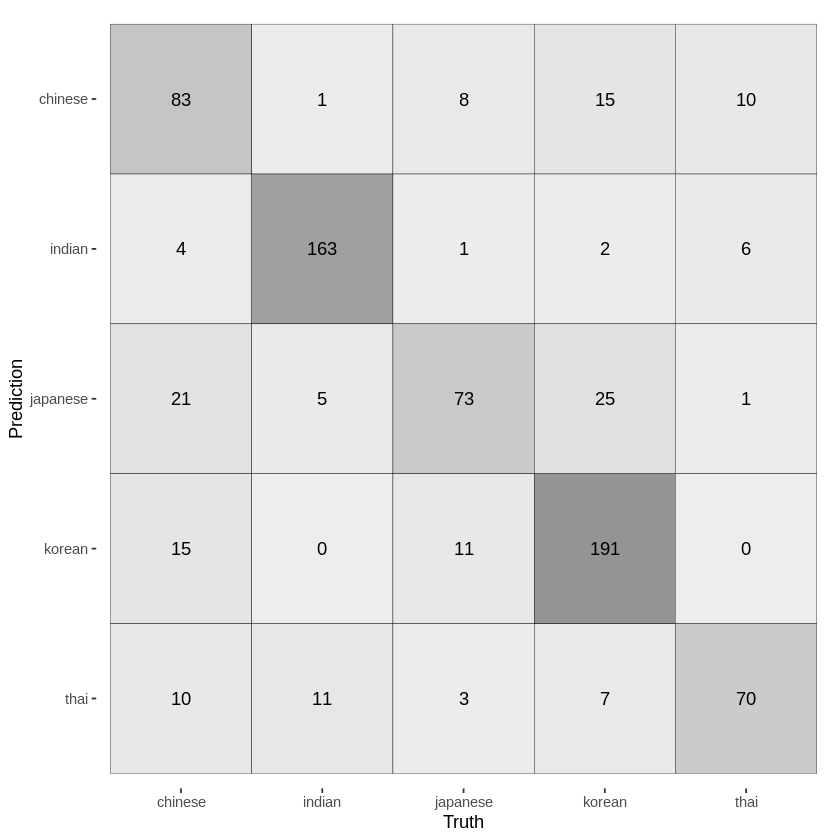

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Pătratele mai închise la culoare din graficul matricei de confuzie indică un număr mare de cazuri, iar, ideal, ar trebui să observați o linie diagonală de pătrate mai închise la culoare care indică cazurile în care eticheta prezisă și cea reală sunt aceleași.

Acum să calculăm statisticile sumare pentru matricea de confuzie.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Dacă ne concentrăm pe câțiva indicatori precum acuratețea, sensibilitatea, ppv, nu stăm deloc rău pentru început 🥳!

## 4. Explorând mai profund

Să punem o întrebare subtilă: Ce criterii sunt folosite pentru a decide un anumit tip de bucătărie ca rezultat prezis?

Ei bine, algoritmii statistici de învățare automată, precum regresia logistică, se bazează pe `probabilitate`; așadar, ceea ce este de fapt prezis de un clasificator este o distribuție de probabilitate peste un set de rezultate posibile. Clasa cu cea mai mare probabilitate este apoi aleasă ca fiind cel mai probabil rezultat pentru observațiile date.

Să vedem acest lucru în acțiune, făcând atât predicții stricte de clasă, cât și probabilități.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Mult mai bine!

✅ Poți explica de ce modelul este destul de sigur că prima observație este thailandeză?

## **🚀Provocare**

În această lecție, ai folosit datele curățate pentru a construi un model de învățare automată care poate prezice o bucătărie națională pe baza unei serii de ingrediente. Ia-ți puțin timp să citești despre [multe opțiuni](https://www.tidymodels.org/find/parsnip/#models) pe care le oferă Tidymodels pentru clasificarea datelor și [alte metode](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) pentru a aplica regresia multinomială.

#### MULȚUMIRI SPECIALE:

[`Allison Horst`](https://twitter.com/allison_horst/) pentru crearea ilustrațiilor uimitoare care fac R mai prietenos și captivant. Găsește mai multe ilustrații în [galeria ei](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) și [Jen Looper](https://www.twitter.com/jenlooper) pentru crearea versiunii originale în Python a acestui modul ♥️

<br>
Aș fi adăugat niște glume, dar nu înțeleg jocurile de cuvinte despre mâncare 😅.

<br>

Învățare plăcută,

[Eric](https://twitter.com/ericntay), Ambasador Gold Microsoft Learn.



---

**Declinarea responsabilității**:  
Acest document a fost tradus folosind serviciul de traducere AI [Co-op Translator](https://github.com/Azure/co-op-translator). Deși ne străduim să asigurăm acuratețea, vă rugăm să rețineți că traducerile automate pot conține erori sau inexactități. Documentul original în limba sa natală ar trebui considerat sursa autoritară. Pentru informații critice, se recomandă traducerea profesională realizată de un specialist uman. Nu ne asumăm răspunderea pentru eventualele neînțelegeri sau interpretări greșite care pot apărea din utilizarea acestei traduceri.
